# Intro to language model

Part 1 - Intro to language modeling:
- Counting bigrams in 2D torch tensor ("training")
- From counts to probabilities (vectorization)
- Sampling from the model
- Loss function
- Smoothing

Part 2 - Simple MLP for Language Modeling:
- Understanding the model
- Simple training loop

Part 3 - Learning subword tokens

Sources: 
- https://github.com/karpathy/nn-zero-to-hero
- https://github.com/karpathy/makemore

Resources:
- https://huggingface.co/course/chapter1/1

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# download the names.txt file from github
!wget -O names.txt https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-14 11:30:15--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-05-14 11:30:15 (11.4 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
len(words)

32033

In [7]:
min(len(w) for w in words)

2

In [8]:
max(len(w) for w in words)

15

Example Bigrams

In [14]:
b = {}
for w in words:
    chars = ["<s>"] + list(w) + ["<e>"]
    for char_1, char_2 in zip(chars, chars[1:]):
        bigram = (char_1, char_2)
        b[bigram] = b.get(bigram, 0) + 1
b

{('<s>', 'e'): 1531,
 ('e', 'm'): 769,
 ('m', 'm'): 168,
 ('m', 'a'): 2590,
 ('a', '<e>'): 6640,
 ('<s>', 'o'): 394,
 ('o', 'l'): 619,
 ('l', 'i'): 2480,
 ('i', 'v'): 269,
 ('v', 'i'): 911,
 ('i', 'a'): 2445,
 ('<s>', 'a'): 4410,
 ('a', 'v'): 834,
 ('v', 'a'): 642,
 ('<s>', 'i'): 591,
 ('i', 's'): 1316,
 ('s', 'a'): 1201,
 ('a', 'b'): 541,
 ('b', 'e'): 655,
 ('e', 'l'): 3248,
 ('l', 'l'): 1345,
 ('l', 'a'): 2623,
 ('<s>', 's'): 2055,
 ('s', 'o'): 531,
 ('o', 'p'): 95,
 ('p', 'h'): 204,
 ('h', 'i'): 729,
 ('<s>', 'c'): 1542,
 ('c', 'h'): 664,
 ('h', 'a'): 2244,
 ('a', 'r'): 3264,
 ('r', 'l'): 413,
 ('l', 'o'): 692,
 ('o', 't'): 118,
 ('t', 't'): 374,
 ('t', 'e'): 716,
 ('e', '<e>'): 3983,
 ('<s>', 'm'): 2538,
 ('m', 'i'): 1256,
 ('a', 'm'): 1634,
 ('m', 'e'): 818,
 ('<s>', 'h'): 874,
 ('r', 'p'): 14,
 ('p', 'e'): 197,
 ('e', 'r'): 1958,
 ('r', '<e>'): 1377,
 ('e', 'v'): 463,
 ('v', 'e'): 568,
 ('l', 'y'): 1588,
 ('y', 'n'): 1826,
 ('n', '<e>'): 6763,
 ('b', 'i'): 217,
 ('i', 'g'): 428,


## Part 1 - Intro to language modeling

### Counting bigrams in 2D torch tensor ("training")

In [15]:
vocab_dim = 27

In [16]:
# https://pytorch.org/docs/stable/torch.html#creation-ops
# Rows: first character, columns: second character
N = torch.zeros((vocab_dim, vocab_dim), dtype=torch.int32)
# Check the the shape
N

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],


Example Tensor/Indexing/Manipulation

In [17]:
# Create a mapping from character to index and from index to character
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [20]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

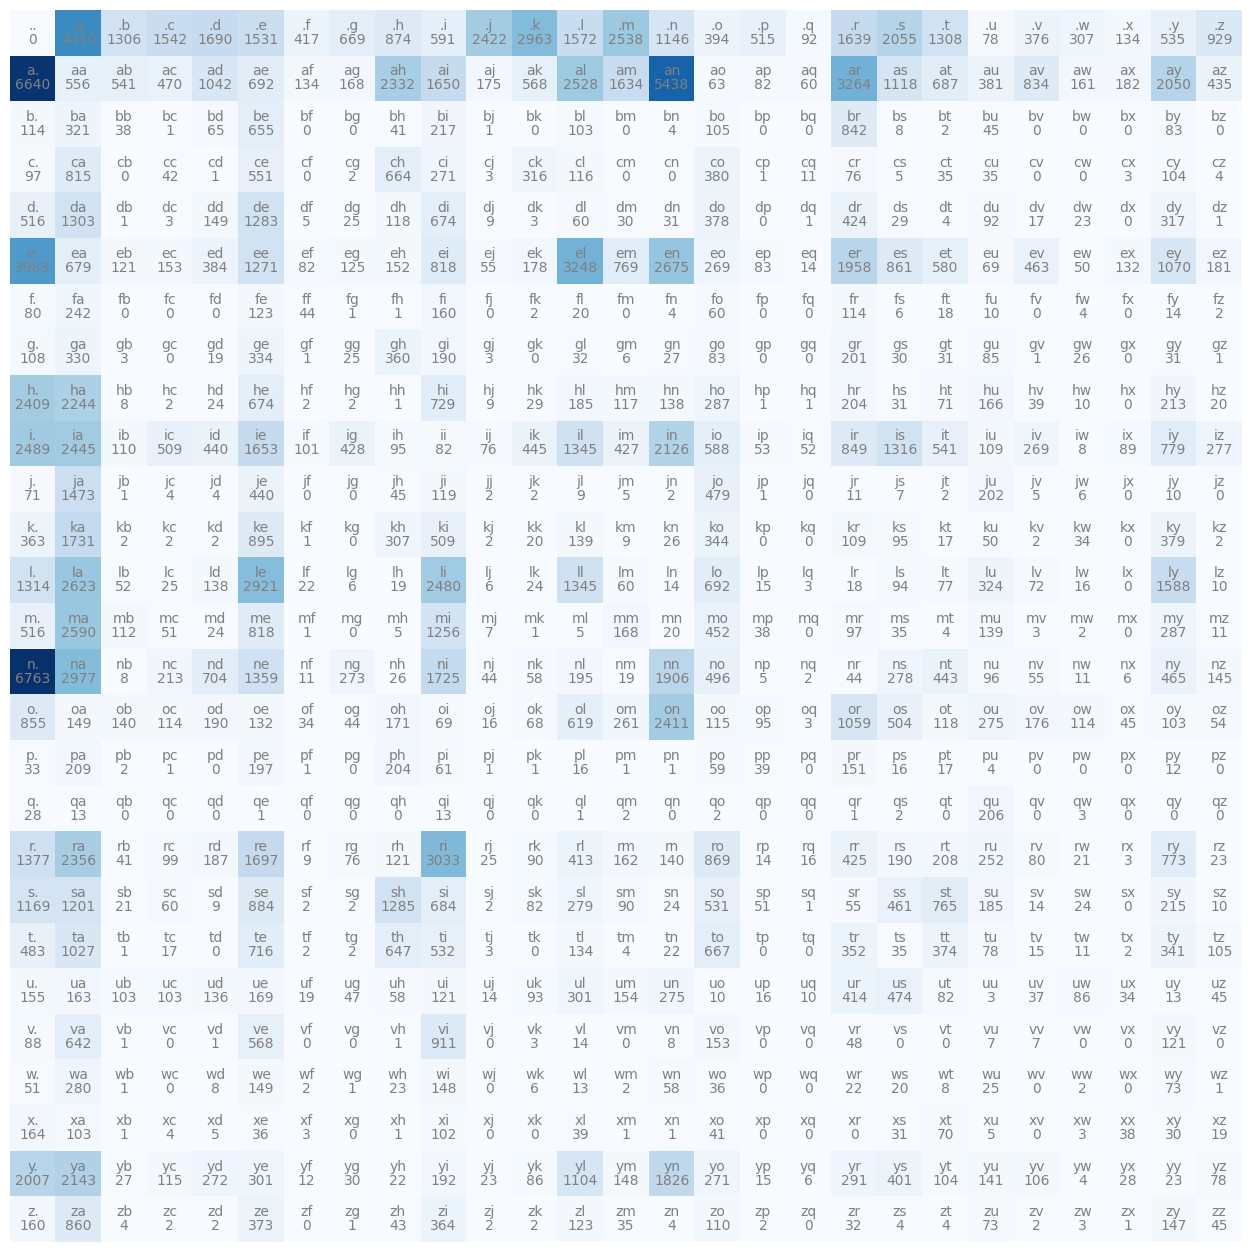

In [21]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_dim):
    for j in range(vocab_dim):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### From counts to probabilities

In [22]:
N[0]


tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Simple normalizing

In [23]:
# Simple normalizing
p = N[-1].float()
# Divides each element of p by the sum of p
p = p / p.sum()
p

tensor([0.0667, 0.3586, 0.0017, 0.0008, 0.0008, 0.1555, 0.0000, 0.0004, 0.0179,
        0.1518, 0.0008, 0.0008, 0.0513, 0.0146, 0.0017, 0.0459, 0.0008, 0.0000,
        0.0133, 0.0017, 0.0017, 0.0304, 0.0008, 0.0013, 0.0004, 0.0613, 0.0188])

Normalizing with broadcasting

In [24]:
# Broadcasting
# https://pytorch.org/docs/stable/notes/broadcasting.html
P = N.float()
# Dim and keep dim
row_sum = P.sum(dim=1, keepdim=True)
print(row_sum.shape)
# Normalize (Copy the column sums across columns)
P /= row_sum

torch.Size([27, 1])


In [25]:
# 27, 27
# 27, 1

In [26]:
P.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [27]:
# Pitfalls of broadcasting
P = N.float()
# dim=1, keep_dim=False
row_sum = P.sum(dim=1)
P /= row_sum
print(row_sum.shape)

torch.Size([27])


In [28]:
P.sum(1)

tensor([7.0225, 4.4142, 0.2009, 0.3717, 0.4146, 2.2968, 0.1063, 0.2065, 0.4567,
        2.3526, 0.2220, 0.3551, 1.0512, 0.4841, 1.3317, 1.1396, 0.1160, 0.0719,
        1.1012, 0.8395, 0.5237, 0.5898, 0.1441, 0.0669, 0.1164, 0.8289, 0.1753])

In [29]:
# 27, 27
#  1  27
# ==> Copys sum across columns over the rows

### Sampling

Starting from the "." token

In [32]:
g = torch.Generator().manual_seed(42)
# What is ix telling us
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
# What is itos[ix]?
itos[ix]

'y'

Generating names

In [34]:
g = torch.Generator().manual_seed(42)

for i in range(1):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out[:-1]))

ye


In [25]:
#Compare against the uniform model

### Loss function
https://en.wikipedia.org/wiki/Maximum_likelihood_estimation

In [35]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling) ==> Slide 9, Lecture 2
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [37]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["wilhelm"]: # "wilhelmq"
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559994.)
nll=tensor(559994.)
2.4545421600341797


### Additive Smoothing
https://en.wikipedia.org/wiki/Additive_smoothing

In [40]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

## Part 2 - Simple MLP for Language Modeling
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

### Understanding the model

In [41]:
# Build the training data

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [42]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [43]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


### Why do we split into train, dev and test ###
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
# Embedding Matrix
C = torch.randn((27, 2)).to(device)

In [45]:
# Dummy training examples
X.shape

torch.Size([32, 3])

In [46]:
X[0]
print("".join([itos[x.item()] for x in X[0]]))

...


In [49]:
one = F.one_hot(X[0], num_classes=27).float()
one @ C
h = (one @ C).mean(0)
h

tensor([-1.6543, -0.7254], device='cuda:0')

In [36]:
# Indexing
C[X[0]]
# C[[0,0,0]]
# C[[0,0,0]].shape

tensor([[ 0.3458, -0.4620],
        [ 0.3458, -0.4620],
        [ 0.3458, -0.4620]], device='cuda:0')

In [50]:
# Index our training examples from our embedding matrix
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [51]:
# Reshaping tensors
emb[0].view(-1,6)

tensor([[-1.6543, -0.7254, -1.6543, -0.7254, -1.6543, -0.7254]],
       device='cuda:0')

In [52]:
# First linear layer | What is the dimension?
W1 = torch.randn((6, 100)).to(device)
b1 = torch.randn(100).to(device)

In [53]:
# Dense intermediate representation of our input
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [54]:
h

tensor([[ 0.6583,  0.8002,  0.8904,  ...,  0.4078, -0.8789, -0.9276],
        [-0.9840, -0.5741, -0.8843,  ..., -0.9912, -0.9995, -0.9525],
        [-0.9920,  0.9984, -0.9853,  ...,  0.8812, -0.9979,  0.8903],
        ...,
        [-0.9646, -1.0000,  0.2717,  ...,  0.9952,  0.9999,  0.9975],
        [-0.9998, -0.9999, -0.1553,  ...,  0.8587, -0.9991,  0.9297],
        [-0.9896, -0.6221, -0.8081,  ...,  0.5957, -0.9990,  0.8709]],
       device='cuda:0')

In [55]:
h.shape

torch.Size([32, 100])

In [56]:
# Up-projection | What is the dimension?
W2 = torch.randn((100, 27)).to(device)
b2 = torch.randn(27).to(device)

In [57]:
logits = h @ W2 + b2

In [58]:
logits.shape

torch.Size([32, 27])

In [59]:
counts = logits.exp()

In [60]:
prob = counts / counts.sum(1, keepdims=True)

In [61]:
prob.shape

torch.Size([32, 27])

In [62]:
F.softmax(logits, dim=1).allclose(prob)

True

In [63]:
Y[:5]

tensor([ 5, 13, 13,  1,  0], device='cuda:0')

In [64]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [65]:
loss = -prob[torch.arange(32), Y].log().mean()
loss.item()

14.28143310546875

In [66]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='cuda:0')

In [67]:
F.cross_entropy(logits, Y).allclose(loss)

True

### Simple training loop

In [68]:
#---putting it together---
vocab_size = len(itos)
emb_dim = 2
block_size = 3
h_dim = 100
g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g).to(device)
W1 = torch.randn((emb_dim * block_size, h_dim), generator=g).to(device)
b1 = torch.randn(h_dim, generator=g).to(device)
W2 = torch.randn((h_dim, vocab_size), generator=g).to(device)
b2 = torch.randn(vocab_size , generator=g).to(device)
parameters = [C, W1, b1, W2, b2]

In [69]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [70]:
for p in parameters:
    print(p.requires_grad)

False
False
False
False
False


In [71]:
for p in parameters:
  p.requires_grad = True

In [72]:
lr=0.1
max_steps = 100000
losses = []
batch_size = 32

for i in range(max_steps):
    # Batching
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,)).to(device) # What do we get here?
    
    # Forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, emb_dim) => (32, 3, 2)
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Reset gradients
    for p in parameters:
        p.grad = None
        
    # Backward pass
    loss.backward()
    
    # Stochastic gradient descent
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())

      0/ 100000: 15.4945
  10000/ 100000: 2.0588
  20000/ 100000: 2.3070
  30000/ 100000: 2.5514
  40000/ 100000: 2.0779
  50000/ 100000: 2.3037
  60000/ 100000: 2.4347
  70000/ 100000: 2.5378
  80000/ 100000: 2.4328
  90000/ 100000: 2.2416


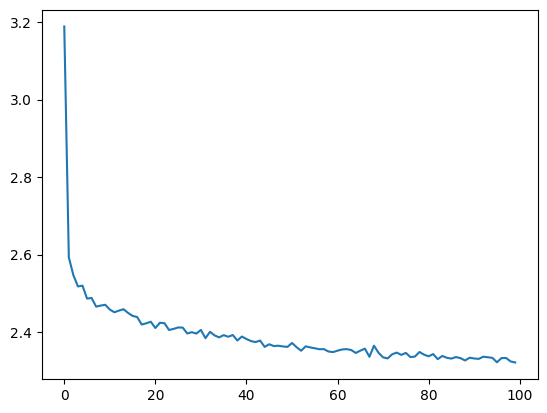

In [73]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [74]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.312504529953003
val 2.314636468887329


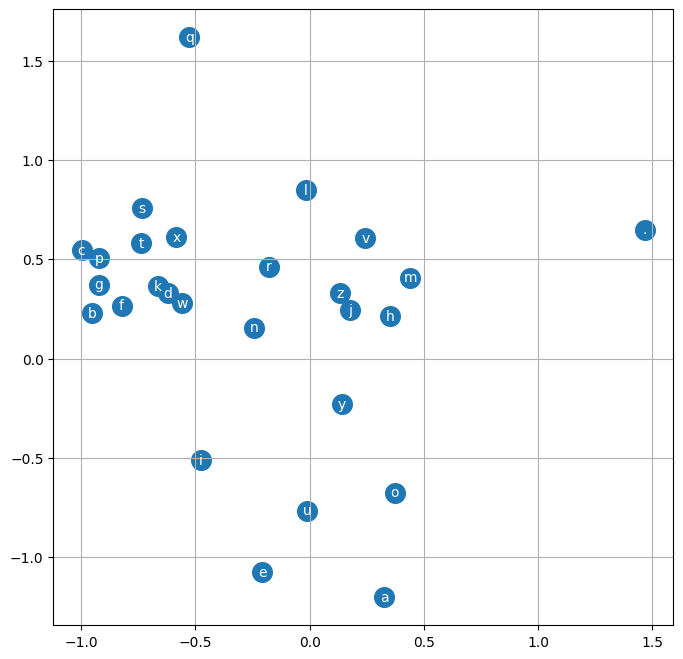

In [75]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [76]:
# sample from the model
g = torch.Generator(device=device).manual_seed(42)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context]).to(device)] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]))

kritariky
jenion
dadar
erlie
airishaiyahibe
live
breya
amurgemin
wyiya
dion
maulinison
tineminlyiesunni
krellay
kahcesust
douqun
erlun
edi
jedi
hamary
keagerryn


In [96]:
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. y
y u
u h
h e
e n
n g
g .


In [97]:
xs

tensor([ 0, 25, 21,  8,  5, 14,  7])

In [98]:
ys

tensor([25, 21,  8,  5, 14,  7,  0])

In [99]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [100]:
xenc.shape

torch.Size([7, 27])

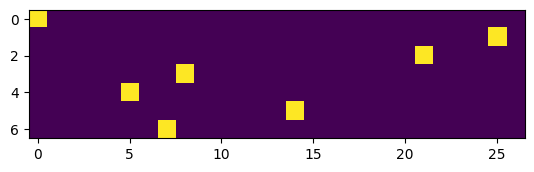

In [101]:
plt.imshow(xenc)

In [102]:
xenc.dtype

torch.float32

In [103]:
W = torch.randn((27, 27))
xenc @ W

tensor([[-0.8825,  0.0482, -1.2546,  0.8156, -0.9571, -0.2574,  0.9723, -0.5019,
         -0.4370, -2.3387,  0.2104,  0.5793, -0.6969,  0.0869,  1.4375, -0.1078,
          0.0726, -1.3696,  0.3462,  1.3894,  0.0495,  0.3223, -0.5303,  1.0941,
         -1.5673, -0.3322, -1.0359],
        [ 1.3737,  0.5421, -0.0684, -1.0444,  0.1309, -1.0957,  0.9853, -0.1760,
          0.7526, -1.1023, -0.5025,  0.1126,  0.6127,  2.7876, -2.3946, -0.7161,
         -2.2085, -0.9741,  0.4581, -1.5040, -1.8226, -0.1822,  1.0374, -1.1276,
          0.5978, -0.9982,  0.4594],
        [ 1.7358,  0.0560,  0.5092,  0.2296,  0.8646,  1.2277, -0.9641, -0.7575,
         -1.3877,  1.0064,  1.3185,  1.0537, -1.5149,  0.3872, -0.3555, -1.0903,
         -1.1364,  0.8322,  1.1257, -0.4887,  0.1314,  0.4584,  0.7375, -0.5234,
         -0.7488, -0.2974, -2.2162],
        [ 0.2435,  0.0518, -0.5159, -0.3808,  0.0729, -3.2566,  2.1043, -0.3432,
         -0.2121, -2.5658, -0.0315,  1.9123,  0.2284,  1.0699,  0.1496,  2.2512

In [104]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0126, 0.0319, 0.0087, 0.0687, 0.0117, 0.0235, 0.0803, 0.0184, 0.0196,
         0.0029, 0.0375, 0.0542, 0.0151, 0.0331, 0.1279, 0.0273, 0.0327, 0.0077,
         0.0429, 0.1219, 0.0319, 0.0419, 0.0179, 0.0907, 0.0063, 0.0218, 0.0108],
        [0.0878, 0.0382, 0.0208, 0.0078, 0.0253, 0.0074, 0.0595, 0.0186, 0.0472,
         0.0074, 0.0134, 0.0249, 0.0410, 0.3610, 0.0020, 0.0109, 0.0024, 0.0084,
         0.0351, 0.0049, 0.0036, 0.0185, 0.0627, 0.0072, 0.0404, 0.0082, 0.0352],
        [0.1362, 0.0254, 0.0399, 0.0302, 0.0570, 0.0819, 0.0092, 0.0113, 0.0060,
         0.0657, 0.0897, 0.0689, 0.0053, 0.0354, 0.0168, 0.0081, 0.0077, 0.0552,
         0.0740, 0.0147, 0.0274, 0.0380, 0.0502, 0.0142, 0.0114, 0.0178, 0.0026],
        [0.0268, 0.0222, 0.0126, 0.0144, 0.0226, 0.0008, 0.1725, 0.0149, 0.0170,
         0.0016, 0.0204, 0.1424, 0.0264, 0.0613, 0.0244, 0.1998, 0.0506, 0.0134,
         0.0467, 0.0267, 0.0088, 0.0068, 0.0072, 0.0255, 0.0140, 0.0048, 0.0153],
        [0.0236, 0.0681,

In [105]:
probs[0]

tensor([0.0126, 0.0319, 0.0087, 0.0687, 0.0117, 0.0235, 0.0803, 0.0184, 0.0196,
        0.0029, 0.0375, 0.0542, 0.0151, 0.0331, 0.1279, 0.0273, 0.0327, 0.0077,
        0.0429, 0.1219, 0.0319, 0.0419, 0.0179, 0.0907, 0.0063, 0.0218, 0.0108])

In [106]:
probs[0].shape

torch.Size([27])

In [107]:
probs[0].sum()

tensor(1.)

In [108]:
xs

tensor([ 0, 25, 21,  8,  5, 14,  7])

In [109]:
ys

tensor([25, 21,  8,  5, 14,  7,  0])

In [110]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [111]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [112]:
probs.shape

torch.Size([7, 27])

In [113]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .y (indexes 0,25)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 25
probability assigned by the net to the the correct character: 0.15368640422821045
log likelihood: -1.8728411197662354
negative log likelihood: 1.8728411197662354
--------
bigram example 2: yu (indexes 25,21)
input to the neural net: 25
output probabilities from the neural net: tensor([0.0301, 0.0080, 0.0090, 0.0151, 0.1318, 0.0101, 0.0206, 0.1885, 0.0614,
        0.0078, 0.0079, 0.0080, 0.0141, 0.0055, 0.0055, 0.0108, 0.0414, 0.0069,
        0.0166, 0.0103, 0.1739, 0.0434, 0.0061, 0.0906, 0.0125, 0.0531, 0.0111])
label (actual next character): 21
probability assigned by the net to the the correct charact

In [114]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [115]:
xs

tensor([ 0, 25, 21,  8,  5, 14,  7])

In [116]:
ys

tensor([25, 21,  8,  5, 14,  7,  0])

In [117]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [123]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(7), ys].log().mean()

In [124]:
print(loss.item())

3.8672845363616943


In [125]:
W.grad = None # set to zero the gradient
loss.backward()

In [126]:
W.data += -0.1 * W.grad

In [127]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [128]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [129]:
# gradient descent
for k in range(1):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.768618583679199


In [131]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjdjdjancqydjufhqyywecnw.
.
oiin.
toziasz.
twt.


How to get to CBOW
- One hot indexing
- Averaging of embeddings
- Simple up-projection

## Part 3: Learning subword tokens (WordPiece)
https://arxiv.org/pdf/1609.08144.pdf

In [68]:
# 1. Example single word "word"
corpus = "word"
vocab = ['w', '##o', '##r', '##d']
split_corpus = [('w', '##o', '##r', '##d', 1)]

In [69]:
# f(t1,t2)/(f(t1)*f(t2))
# Intuition: Dampen the effect of generally frequent tokens

In [70]:
# 2. Example 
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u"]
split_corpus = ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)
# First merge ==> ##g,##s ==> ##gs
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs"]
split_corpus = ("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##gs", 5)
# Second merge ==> h, ##u
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu"]
split_corpus = ("hu" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
# Third merge ==> hu, ##g
vocab = ["b", "h", "p", "##g", "##n", "##s", "##u", "##gs", "hu", "hug"]
split_corpus = ("hug", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("hu" "##gs", 5)
# Continue until desired vocab size is reached

In [71]:
# Tokenization of token "hugs"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "hug"
# 2. Split the token:
split = ["hug", "##s"]
# 1. Find longest subword starting from the beginning in the vocabulary ==> "##s"
tokenization = ["hug", "##s"]

In [72]:
# Tokenization of the token "mug"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "[UNK]" ("m" is not in the vocabulary)
tokenization = ["[UNK]"]

In [73]:
# Tokenization of the word "bum"
# 1. Find longest subword starting from the beginning in the vocabulary ==> "b"
# 2. Split the token:
split = ["b", "##um"]
# 1. Find longest subword starting from the beginning in the vocabulary ==> "##u"
# 2. Split the token:
split = ["b", "##u", '##m']
# 1. Find longest subword starting from the beginning in the vocabulary ==> "[UNK]"
tokenization = ["[UNK]"]

In [74]:
# Apply text preprocessing (normalization, pre-tokenization) if working text 

# Getting the word frequencies
word_freqs = defaultdict(int)
for word in words:
    word_freqs[word] += 1

print(list(word_freqs.items()))
# word_freqs

[('yuheng', 1), ('diondre', 1), ('xavien', 1), ('jori', 2), ('juanluis', 1), ('erandi', 1), ('phia', 1), ('samatha', 1), ('phoenix', 2), ('emmelynn', 1), ('hollan', 1), ('hollis', 2), ('callalily', 1), ('adelayde', 1), ('josephyne', 1), ('weldon', 1), ('kayle', 1), ('ragnar', 1), ('colbie', 2), ('taveon', 1), ('aki', 2), ('peyten', 1), ('kevari', 1), ('joella', 1), ('mecca', 2), ('egan', 1), ('justyce', 2), ('taliyah', 1), ('hayley', 1), ('alleah', 1), ('kymberlynn', 1), ('parrish', 2), ('houstyn', 1), ('jamaya', 1), ('ahmod', 1), ('nivin', 1), ('milli', 1), ('cristiana', 1), ('jaimee', 1), ('mitchell', 2), ('nairah', 1), ('lorena', 1), ('gentrie', 1), ('torrion', 1), ('savian', 1), ('benjamine', 1), ('airess', 1), ('knute', 1), ('sultana', 1), ('danai', 1), ('azzan', 1), ('issabelle', 1), ('abrahim', 1), ('aislyn', 1), ('aerys', 2), ('malaiya', 1), ('kieon', 1), ('ayansh', 1), ('berklee', 2), ('emmakate', 1), ('avaneesh', 1), ('amenadiel', 1), ('renardo', 1), ('brekken', 1), ('kamry',

In [75]:
# Getting the alphabet (pre-vocab)
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
print(alphabet)
        

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [76]:
# In case of pretrained language models more special tokens are used ("[UNK]", "[CLS]", ...)
vocab = ["."] + alphabet.copy()
print(vocab)

['.', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [77]:
# Create our splitted corpus: {"emma": [e, ##m, ##m, ##a]}
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}
print(list(splits.items())[:5])

[('yuheng', ['y', '##u', '##h', '##e', '##n', '##g']), ('diondre', ['d', '##i', '##o', '##n', '##d', '##r', '##e']), ('xavien', ['x', '##a', '##v', '##i', '##e', '##n']), ('jori', ['j', '##o', '##r', '##i']), ('juanluis', ['j', '##u', '##a', '##n', '##l', '##u', '##i', '##s'])]


In [78]:
# "Training" aka learn the merges
# Compute the score for each pair that can be constructed from splits
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items(): 
        split = splits[word] 
        if len(split) == 1:
            # Word is a single token
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            # Construct pairs from left to right
            pair = (split[i], split[i + 1])
            # Update the frequency of the current "letter"/subword
            letter_freqs[split[i]] += freq
            # Update the frequency of the pair
            pair_freqs[pair] += freq
        # Update the frequency of the last "letter"/subword
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [79]:
# Let´s look at the first scores
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('y', '##u'): 5.258346861347788e-05
('##u', '##h'): 2.814127736363198e-06
('##h', '##e'): 4.106151828818785e-06
('##e', '##n'): 8.056479724665693e-06
('##n', '##g'): 1.2399544029901778e-05
('d', '##i'): 4.495796430337634e-06


In [80]:
# Get the best pair
max(pair_scores.items(), key=lambda kv: kv[1])

(('q', '##u'), 0.0002915617755401004)

In [81]:
# Append to vocab
vocab.append("qu")

In [82]:
# Apply the update vocabulary to splits
def merge_pair(a, b, splits):
    for word in word_freqs: # yuheng
        split = splits[word] # ['y', '##u', '##h', '##e', '##n', '##g']
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [83]:
splits = merge_pair("q", "##u", splits)
splits["quinn"]

['qu', '##i', '##n', '##n']

In [84]:
# Let´s build our vocabulary
vocab_size = 200
while len(vocab) < vocab_size:
    # Compute pair scores
    scores = compute_pair_scores(splits)
    # Get best pair
    best_pair, max_score = max(scores.items(), key=lambda kv: kv[1])
    # Update splits / corpus (merge)
    splits = merge_pair(*best_pair, splits)
    # Add new token to vocab
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [85]:
print(vocab)

['.', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##j', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu', 'qw', '##qu', '##ff', '##pp', '##xx', '##ck', 'iz', 'izz', 'iq', '##uq', 'ruq', 'luq', 'luqm', '##ouq', '##rouq', '##ruq', 'gw', 'xz', 'yu', 'yux', 'yuxu', 'yuv', 'yuxi', 'yuj', 'yuji', 'uz', 'uzz', 'uzzi', 'qwy', 'qwyn', 'qwynn', '##cqu', 'qwe', 'qwes', 'qwest', '##uw', '##luw', 'oluw', '##juw', 'ruw', 'juw', '##suw', '##oluw', '##juwo', 'toluw', 'ow', '##foluw', '##nfoluw', '##infoluw', '##yinfoluw', '##iyinfoluw', 'fiyinfoluw', '##juwon', '##xxw', '##esuw', '##desuw', 'adesuw', '##xxwe', '##xxwel', '##xxwell', '##ph', 'up', 'upt', 'upto', 'upton', 'yuk', '##cque', '##cqul', '##cquez', '##cquli', '##cqulin', '##cquel', '##cques', '##cquely', '##cquelyn', '##cquline'

In [86]:
# Encode a word, search for the longest substring
def encode_word(word): # emma
    tokens = []
    while len(word) > 0:
        i = len(word) # i = 4
        while i > 0 and word[:i] not in vocab:
            i -= 1
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [87]:
print(encode_word("emma"))
print(encode_word("quinn"))

['emm', '##a']
['qu', '##i', '##n', '##n']


### Coding Exercises:
- "Train" a subword level bigram or a character level trigram model
- "Train" a character level bigram model on tiny shakespeare
- Train a character level bigram model with stochastic gradient descent (no counting, but learn the probabilities via gradient descent and backprop)
- Train a simple MLP on tiny shakespeare
- Add the residual connection to the simple MLP

### 

### Pen & Paper Exercises:

- Build the subword vocabulary with a vocabulary size of 10 for the following sentence: "hug pup hug pup pun hugs hug pup un" using WordPiece. Don´t add the "." token to your alphabet.
    - Solution: ['##g', '##n', '##p', '##s', '##u', 'h', 'p', 'u', 'un', '##gs']
- Tokenize the word "hug" with your learned vocabulary using WordPiece.
    - Solution: ['h', '##u', '##g']
- Compute the character-level bigram probabilities for the following corpus using additive smoothing (+ 1): ["baba", "abba", "abba", "abab", "bbba"]. Build all possible bigrams: ["..", ".a", ".b", "a.", "b.", "aa", "ab", "ba", "bb"].
    - Solution:
        - ..: 0.125
        - .a: 0.500
        - .b: 0.3750
        - a.: 0.4167
        - b.: 0.1429
        - aa: 0.0833
        - ab: 0.5000
        - ba: 0.5000
        - bb: 0.3571
- Compute the unnormalized negative log-likelihood of the word "bab" in your character-level bigram model:
    - Solution: 4.3130
- Compute the logits for a CBOW model
    - Sentence: "Frodo and Sam fight the orks"
    - Vocab: ["Frodo", "Sam", "fight", "the", "orks"]
    - Compute the logits for a CBOW model for the word "fight" being the center word with a window size of 2 given the matrics W1 and W2 (below)
    - Solution: [ 0.6394, -0.7976, -0.1091,  1.5486, -0.9377]
- What are the differences between BPE and WordPiece and SentencePiece?

In [ ]:
W1 = [[ 0.4128, -0.2592, -0.5713, -0.9116],
 [-0.6286,  0.1850,  0.8611,  0.3844],
 [ 2.0777,  0.2960, -0.7118,  1.0722],
 [-1.0484,  0.9931,  0.2309,  2.5170],
 [ 1.8805,  1.0564,  1.7468,  0.2562]]

In [ ]:
W2 = [[-0.9120, -0.7972, -0.1510, -0.0237, -0.1716],
 [-0.0279, -0.2131, -1.2196, -0.1247,  0.0168],
 [ 0.9730, -1.0510, -0.6692,  1.5317, -1.4178],
 [ 0.4312,  0.0468,  1.5954,  1.3278, -0.2063]]

Self-found exercises for BPE

In [157]:
from collections import defaultdict

from transformers import AutoTokenizer

In [158]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [159]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

/home/jovyan/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [160]:
word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [161]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [162]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [163]:
splits = {word: [c for c in word] for word in word_freqs.keys()}
splits

{'This': ['T', 'h', 'i', 's'],
 'Ġis': ['Ġ', 'i', 's'],
 'Ġthe': ['Ġ', 't', 'h', 'e'],
 'ĠHugging': ['Ġ', 'H', 'u', 'g', 'g', 'i', 'n', 'g'],
 'ĠFace': ['Ġ', 'F', 'a', 'c', 'e'],
 'ĠCourse': ['Ġ', 'C', 'o', 'u', 'r', 's', 'e'],
 '.': ['.'],
 'Ġchapter': ['Ġ', 'c', 'h', 'a', 'p', 't', 'e', 'r'],
 'Ġabout': ['Ġ', 'a', 'b', 'o', 'u', 't'],
 'Ġtokenization': ['Ġ',
  't',
  'o',
  'k',
  'e',
  'n',
  'i',
  'z',
  'a',
  't',
  'i',
  'o',
  'n'],
 'Ġsection': ['Ġ', 's', 'e', 'c', 't', 'i', 'o', 'n'],
 'Ġshows': ['Ġ', 's', 'h', 'o', 'w', 's'],
 'Ġseveral': ['Ġ', 's', 'e', 'v', 'e', 'r', 'a', 'l'],
 'Ġtokenizer': ['Ġ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', 'r'],
 'Ġalgorithms': ['Ġ', 'a', 'l', 'g', 'o', 'r', 'i', 't', 'h', 'm', 's'],
 'Hopefully': ['H', 'o', 'p', 'e', 'f', 'u', 'l', 'l', 'y'],
 ',': [','],
 'Ġyou': ['Ġ', 'y', 'o', 'u'],
 'Ġwill': ['Ġ', 'w', 'i', 'l', 'l'],
 'Ġbe': ['Ġ', 'b', 'e'],
 'Ġable': ['Ġ', 'a', 'b', 'l', 'e'],
 'Ġto': ['Ġ', 't', 'o'],
 'Ġunderstand': ['Ġ', 'u', 'n'

In [164]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [165]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


In [166]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


In [167]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [168]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [169]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [170]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [171]:
merges

{('Ġ', 't'): 'Ġt',
 ('i', 's'): 'is',
 ('e', 'r'): 'er',
 ('Ġ', 'a'): 'Ġa',
 ('Ġt', 'o'): 'Ġto',
 ('e', 'n'): 'en',
 ('T', 'h'): 'Th',
 ('Th', 'is'): 'This',
 ('o', 'u'): 'ou',
 ('s', 'e'): 'se',
 ('Ġto', 'k'): 'Ġtok',
 ('Ġtok', 'en'): 'Ġtoken',
 ('n', 'd'): 'nd',
 ('Ġ', 'is'): 'Ġis',
 ('Ġt', 'h'): 'Ġth',
 ('Ġth', 'e'): 'Ġthe',
 ('i', 'n'): 'in',
 ('Ġa', 'b'): 'Ġab',
 ('Ġtoken', 'i'): 'Ġtokeni'}

In [172]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

In [173]:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

Self-found exercises by WordPiece

In [174]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [175]:

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [176]:
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

In [177]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

['##a',
 '##b',
 '##c',
 '##d',
 '##e',
 '##f',
 '##g',
 '##h',
 '##i',
 '##k',
 '##l',
 '##m',
 '##n',
 '##o',
 '##p',
 '##r',
 '##s',
 '##t',
 '##u',
 '##v',
 '##w',
 '##y',
 '##z',
 ',',
 '.',
 'C',
 'F',
 'H',
 'T',
 'a',
 'b',
 'c',
 'g',
 'h',
 'i',
 's',
 't',
 'u',
 'w',
 'y']

In [178]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
vocab

['[PAD]',
 '[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 '##a',
 '##b',
 '##c',
 '##d',
 '##e',
 '##f',
 '##g',
 '##h',
 '##i',
 '##k',
 '##l',
 '##m',
 '##n',
 '##o',
 '##p',
 '##r',
 '##s',
 '##t',
 '##u',
 '##v',
 '##w',
 '##y',
 '##z',
 ',',
 '.',
 'C',
 'F',
 'H',
 'T',
 'a',
 'b',
 'c',
 'g',
 'h',
 'i',
 's',
 't',
 'u',
 'w',
 'y']

In [179]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}
splits

{'This': ['T', '##h', '##i', '##s'],
 'is': ['i', '##s'],
 'the': ['t', '##h', '##e'],
 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'],
 'Face': ['F', '##a', '##c', '##e'],
 'Course': ['C', '##o', '##u', '##r', '##s', '##e'],
 '.': ['.'],
 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'],
 'about': ['a', '##b', '##o', '##u', '##t'],
 'tokenization': ['t',
  '##o',
  '##k',
  '##e',
  '##n',
  '##i',
  '##z',
  '##a',
  '##t',
  '##i',
  '##o',
  '##n'],
 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'],
 'shows': ['s', '##h', '##o', '##w', '##s'],
 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'],
 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'],
 'algorithms': ['a',
  '##l',
  '##g',
  '##o',
  '##r',
  '##i',
  '##t',
  '##h',
  '##m',
  '##s'],
 'Hopefully': ['H', '##o', '##p', '##e', '##f', '##u', '##l', '##l', '##y'],
 ',': [','],
 'you': ['y', '##o', '##u'],
 'will': ['w', '##i', '##l', '##l'],
 'be': ['b', '##e

In [180]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [181]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('T', '##h'): 0.125
('##h', '##i'): 0.03409090909090909
('##i', '##s'): 0.02727272727272727
('i', '##s'): 0.1
('t', '##h'): 0.03571428571428571
('##h', '##e'): 0.011904761904761904


In [182]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('a', '##b') 0.2


In [183]:
vocab.append("ab")

In [184]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [185]:
splits = merge_pair("a", "##b", splits)
splits["about"]

['ab', '##o', '##u', '##t']

In [186]:
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [187]:
vocab

['[PAD]',
 '[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 '##a',
 '##b',
 '##c',
 '##d',
 '##e',
 '##f',
 '##g',
 '##h',
 '##i',
 '##k',
 '##l',
 '##m',
 '##n',
 '##o',
 '##p',
 '##r',
 '##s',
 '##t',
 '##u',
 '##v',
 '##w',
 '##y',
 '##z',
 ',',
 '.',
 'C',
 'F',
 'H',
 'T',
 'a',
 'b',
 'c',
 'g',
 'h',
 'i',
 's',
 't',
 'u',
 'w',
 'y',
 'ab',
 '##fu',
 'Fa',
 'Fac',
 '##ct',
 '##ful',
 '##full',
 '##fully',
 'Th',
 'ch',
 '##hm',
 'cha',
 'chap',
 'chapt',
 '##thm',
 'Hu',
 'Hug',
 'Hugg',
 'sh',
 'th',
 'is',
 '##thms',
 '##za',
 '##zat',
 '##ut']

In [188]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [189]:
print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


In [190]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [191]:
tokenize("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

Self-found exercises Unigram

In [204]:
from math import log
import copy

In [192]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [193]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

/home/jovyan/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [194]:
word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'▁This': 3,
             '▁is': 2,
             '▁the': 1,
             '▁Hugging': 1,
             '▁Face': 1,
             '▁Course.': 1,
             '▁chapter': 1,
             '▁about': 1,
             '▁tokenization.': 1,
             '▁section': 1,
             '▁shows': 1,
             '▁several': 1,
             '▁tokenizer': 1,
             '▁algorithms.': 1,
             '▁Hopefully,': 1,
             '▁you': 1,
             '▁will': 1,
             '▁be': 1,
             '▁able': 1,
             '▁to': 1,
             '▁understand': 1,
             '▁how': 1,
             '▁they': 1,
             '▁are': 1,
             '▁trained': 1,
             '▁and': 1,
             '▁generate': 1,
             '▁tokens.': 1})

In [195]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
sorted_subwords[:10]

[('▁t', 7),
 ('is', 5),
 ('er', 5),
 ('▁a', 5),
 ('▁to', 4),
 ('to', 4),
 ('en', 4),
 ('▁T', 3),
 ('▁Th', 3),
 ('▁Thi', 3)]

In [196]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

In [197]:
token_freqs

{'▁': 31,
 'T': 3,
 'h': 9,
 'i': 13,
 's': 13,
 't': 14,
 'e': 21,
 'H': 2,
 'u': 6,
 'g': 5,
 'n': 11,
 'F': 1,
 'a': 12,
 'c': 3,
 'C': 1,
 'o': 13,
 'r': 9,
 '.': 4,
 'p': 2,
 'b': 3,
 'k': 3,
 'z': 2,
 'w': 3,
 'v': 1,
 'l': 7,
 'm': 1,
 'f': 1,
 'y': 3,
 ',': 1,
 'd': 4,
 '▁t': 7,
 'is': 5,
 'er': 5,
 '▁a': 5,
 '▁to': 4,
 'to': 4,
 'en': 4,
 '▁T': 3,
 '▁Th': 3,
 '▁Thi': 3,
 '▁This': 3,
 'Th': 3,
 'Thi': 3,
 'This': 3,
 'hi': 3,
 'his': 3,
 'th': 3,
 'ou': 3,
 'se': 3,
 '▁tok': 3,
 '▁toke': 3,
 '▁token': 3,
 'tok': 3,
 'toke': 3,
 'token': 3,
 'ok': 3,
 'oke': 3,
 'oken': 3,
 'ke': 3,
 'ken': 3,
 '▁s': 3,
 'ra': 3,
 'nd': 3,
 '▁i': 2,
 '▁is': 2,
 '▁th': 2,
 '▁the': 2,
 'the': 2,
 'he': 2,
 '▁H': 2,
 'in': 2,
 'rs': 2,
 'te': 2,
 '▁ab': 2,
 'ab': 2,
 '▁tokeni': 2,
 '▁tokeniz': 2,
 'tokeni': 2,
 'tokeniz': 2,
 'okeni': 2,
 'okeniz': 2,
 'keni': 2,
 'keniz': 2,
 'eni': 2,
 'eniz': 2,
 'ni': 2,
 'niz': 2,
 'iz': 2,
 'at': 2,
 'ti': 2,
 'tio': 2,
 'tion': 2,
 'io': 2,
 'ion': 2,
 'on':

In [199]:
total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

In [200]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):
        # This should be properly filled by the previous steps of the loop
        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

In [201]:
print(encode_word("Hopefully", model))
print(encode_word("This", model))

(['H', 'o', 'p', 'e', 'f', 'u', 'll', 'y'], 41.5157494601402)
(['This'], 6.288267030694535)


In [202]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

In [203]:
compute_loss(model)

413.10377642940875

In [206]:
def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in model.items():
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

In [207]:
scores = compute_scores(model)
print(scores["ll"])
print(scores["his"])

6.376412403623874
0.0


In [208]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

In [209]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [210]:
tokenize("This is the Hugging Face course.", model)

['▁This',
 '▁is',
 '▁the',
 '▁Hugging',
 '▁Face',
 '▁',
 'c',
 'ou',
 'r',
 's',
 'e',
 '.']